<h1 align="center"><font face = "Times New Roman" size = "80">Demo of pipeline</font></h1>
<h2 align="center"><font face = "Times New Roman" size = ""> Information theory and coding</font></h2>
<h3 align="center"><font face = "Times New Roman"> Fall 2019</font></h3>
<h5 align="center"><font face = "Times New Roman"">Alaa Mohamed Roshdy&nbsp 201600031</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Adham Mahrous&nbsp 201601078</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Mostafa Hamed&nbsp 201600236</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Kasem Saber&nbsp 201601144</font></h5>




---



## Encoding frames

In [18]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import Video # To display the video in the notebook
import numpy as np

In [19]:
import julia 
import Encoder as E
jl = julia.Julia()
jl.include('bac.jl')
jl.include('motion_estimation.jl')
path="mountain.mp4"
predictedPerRef=3 
no_frames = 5
Resolution=1
vid_frame=E.get_video_frames(path,no_frames,Resolution)
vid_frame=E.interlace_comp_frames(vid_frame)
ref_frames=vid_frame[::predictedPerRef]
n_predicted_frames = no_frames - int(np.ceil(len(vid_frame)/predictedPerRef))
residual_frames_y = np.zeros((n_predicted_frames, vid_frame[0][0].shape[0], vid_frame[0][0].shape[1]), dtype = int)
residual_frames_cb = np.zeros((n_predicted_frames, vid_frame[0][1].shape[0], vid_frame[0][1].shape[1]), dtype = int)
residual_frames_cr= np.zeros((n_predicted_frames, vid_frame[0][2].shape[0], vid_frame[0][2].shape[1]), dtype = int)

vid_mv = np.zeros((n_predicted_frames, int(vid_frame[0][0].shape[0]/16), int(vid_frame[0][0].shape[1]/16), 2), dtype = int)
c=1
for j in range(0,int(np.ceil(len(vid_frame)/predictedPerRef))):

    #Reshaping the reference frames to use in the coming blocks
    im_ref_y,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][0]))
    im_ref_cb,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][1],8),8)
    im_ref_cr,_,_=E.get_sub_images(E.reshape_image(ref_frames[j][2],8),8)


    for i in range(0,predictedPerRef-1):
        #print(ref_frames[j][0])
        #Reshaping the current frame 
        current_im_blocks, nrows, ncols = E.get_sub_images(E.reshape_image(vid_frame[c][0]))

        #Motion estimation 
        mv = jl.motion_estimation_to_all(ref_frames[j][0], current_im_blocks, nrows, ncols)
        print(j)

        #Motion Compensation
        p_image_y = E.predict(im_ref_y,mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1],16)
        mv_cb=np.zeros(mv.shape,dtype=int)
        for x in range(mv.shape[0]):
            for z in range(mv.shape[1]):
                mv_cb[x][z][0]=np.int(mv[x][z][0]/2)
                mv_cb[x][z][1]=np.int(mv[x][z][1]/2)

        p_image_cb=E.predict(im_ref_cb,mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1],8)
        p_image_cr=E.predict(im_ref_cr,mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1],8)

        #Calculating the residuals
        res_index = int(c - np.ceil(j/predictedPerRef) - 1)
        residual_frames_y[res_index]=E.residual(vid_frame[c][0],p_image_y)
        residual_frames_cb[res_index]=E.residual(vid_frame[c][1],p_image_cb)
        residual_frames_cr[res_index]=E.residual(vid_frame[c][2],p_image_cr)
        
        vid_mv[res_index] = mv
        c+=1
        if(c>len(vid_frame)-1):
            break
    c+=1

0
0
1


In [20]:
jl.include('bin_and_bac.jl')

<PyCall.jlwrap decode_bin_bac>

In [21]:
quantized_coeff_y = []
quantized_coeff_cb = []
quantized_coeff_cr = []
for j in range(0,n_predicted_frames):
    quantized_coeff_y.append(E.spatial_model(residual_frames_y[j], 16))
    
    quantized_coeff_cb.append(E.spatial_model(residual_frames_cb[j], 8))
    
    quantized_coeff_cr.append(E.spatial_model(residual_frames_cr[j], 8))

In [22]:
data = jl.encode_bin_bac(vid_mv, predictedPerRef, no_frames, (quantized_coeff_y,quantized_coeff_cb,quantized_coeff_cr), ref_frames)

In [23]:
dvid_mv, dresiduals, dref_frames = jl.decode_bin_bac(data)

In [32]:
dquantized_coeff_y,dquantized_coeff_cb,dquantized_coeff_cr = dresiduals

## Checking that the decoder output is the same as the encoder input

In [26]:
(dvid_mv == vid_mv).mean()

1.0

In [31]:
for i in range(len(dref_frames)):
    for j in range(dref_frames[i].shape[0]):
        print((dref_frames[i][j] == ref_frames[j][i]).mean())

1.0
1.0
1.0
1.0
1.0
1.0


In [39]:
for i in range(len(dquantized_coeff_y)):
    print((dquantized_coeff_y[i] == quantized_coeff_y[i]).mean())
    print((dquantized_coeff_cb[i] == quantized_coeff_cb[i]).mean())    
    print((dquantized_coeff_cr[i] == quantized_coeff_cr[i]).mean())    

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


## Decoding frames

In [41]:
quantized_residual_y = np.zeros((n_predicted_frames, vid_frame[0][0].shape[0], vid_frame[0][0].shape[1]), dtype = int)
quantized_residual_cb = np.zeros((n_predicted_frames, vid_frame[0][1].shape[0], vid_frame[0][1].shape[1]), dtype = int)
quantized_residual_cr= np.zeros((n_predicted_frames, vid_frame[0][2].shape[0], vid_frame[0][2].shape[1]), dtype = int)
for j in range(0,predictedPerRef-1):
    quantized_residual_y[j] = E.spatial_inverse_model(dquantized_coeff_y[j], nrows, ncols, 16)

    quantized_residual_cb[j] =  E.spatial_inverse_model(dquantized_coeff_cb[j], nrows, ncols, 8)

    quantized_residual_cr[j] = E.spatial_inverse_model(dquantized_coeff_cr[j], nrows, ncols, 8) 

In [43]:
Reconstruced_frames=[]
c=0
for j in range(0,np.int(no_frames/predictedPerRef)):
    Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(ref_frames[j])))

    #Reshaping the reference frames to use in the coming blocks
    im_ref_y,_,_=E.get_sub_images(E.reshape_image(dref_frames[0][j]))
    im_ref_cb,_,_=E.get_sub_images(E.reshape_image(dref_frames[1][j],8),8)
    im_ref_cr,_,_=E.get_sub_images(E.reshape_image(dref_frames[2][j],8),8)
    for i in range(0,predictedPerRef-1):
        #inverse spatial
        #residual_blocks, n_rows, n_cols = E.spatial_inverse_model(vid_residuals[c])
        #residual_frame = E.get_reconstructed_image(residual_blocks, n_rows, n_cols)
        mv=dvid_mv[c]
        for i in range(mv.shape[0]):
            for j in range(mv.shape[1]):
                mv_cb[i][j][0]=np.int(mv[i][j][0]/2)
                mv_cb[i][j][1]=np.int(mv[i][j][1]/2)
        #getting the predicted image
        p_image_y = E.predict(im_ref_y, mv, ref_frames[0][0].shape[0], ref_frames[0][0].shape[1])
        p_image_cb = E.predict(im_ref_cb, mv_cb, ref_frames[0][1].shape[0], ref_frames[0][1].shape[1], 8)
        p_image_cr = E.predict(im_ref_cr, mv_cb, ref_frames[0][2].shape[0], ref_frames[0][2].shape[1], 8)
        #adding the residuals to get the reconstructed image

        Reconstructed_y = p_image_y + quantized_residual_y[c]
        Reconstructed_cb = p_image_cb + quantized_residual_cb[c]
        Reconstructed_cr = p_image_cr + quantized_residual_cr[c]

        Reconstructed_interlaced=[Reconstructed_y,Reconstructed_cb,Reconstructed_cr]
        Reconstruced_frames.append(E.conv_decom_YUV2RGB(E.deinterlace_comp_frames(Reconstructed_interlaced)))
        c+=1

In [45]:
import cv2

Text(0.5, 1.0, 'last predicted frame')

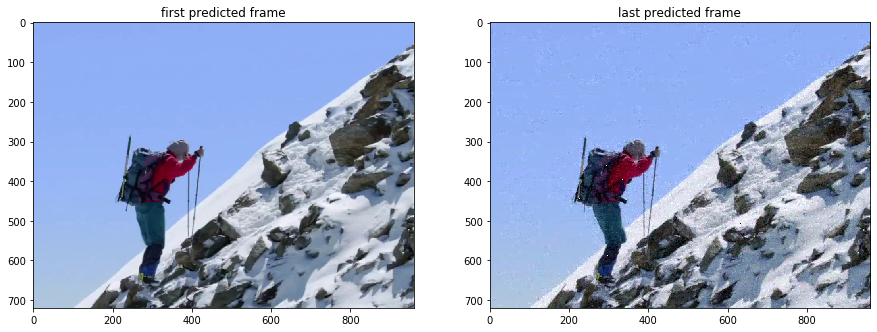

In [52]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15,15))

ax1.imshow(cv2.cvtColor(Reconstruced_frames[0], cv2.COLOR_BGR2RGB))
ax1.set_title("first predicted frame")


ax2.imshow(cv2.cvtColor(Reconstruced_frames[2], cv2.COLOR_BGR2RGB))
ax2.set_title("last predicted frame")